<a href="https://colab.research.google.com/github/hiimjupter/COS40007/blob/main/Portfolio4_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install -U labelme2coco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 11.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114250 sha256=9643c87eccf90afc1dde61dbb9dcfde5369fc6e2ca492e4bf3d110b14606af97
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


In [ ]:
import os
import random
import shutil

import cv2

from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
from torchvision.utils import draw_bounding_boxes, save_image
from torchvision.transforms import functional as F

import PIL
from PIL import Image, ImageDraw, ImageFont

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F

from tqdm import tqdm

import labelme2coco
from pycocotools.coco import COCO

In [ ]:
HOME_DIR = '/content/drive/MyDrive/COS40007/Portfolio4'
DATA_DIR = os.path.join(HOME_DIR, 'Dataset')

LOG_DATASET = os.path.join(DATA_DIR, 'log-labelled')
COCO_ANNOTATION = os.path.join(DATA_DIR, 'coco-annotations')

os.makedirs(COCO_ANNOTATION, exist_ok=True)

In [ ]:
image_files = [f for f in os.listdir(LOG_DATASET) if f.endswith('.png')]
json_files = [f for f in os.listdir(LOG_DATASET) if f.endswith('.json')]
print(f"Number of images: {len(image_files)}")
print(f"Number of json files: {len(json_files)}")

Number of images: 600
Number of json files: 600


In [ ]:
def remove_unmatched_files(folder_path):
    # Get all files in the folder
    files = os.listdir(folder_path)
    # Create sets of PNG and JSON filenames (without extensions)
    png_files = {os.path.splitext(file)[0] for file in files if file.endswith('.png')}
    json_files = {os.path.splitext(file)[0] for file in files if file.endswith('.json')}

    # Find unmatched PNG files
    unmatched_png_files = png_files - json_files
    unmatched_json_files = json_files - png_files

    # Remove unmatched PNG files
    for file in unmatched_png_files:
        file_path = os.path.join(folder_path, file + '.png')
        os.remove(file_path)
        print(f'Removed unmatched PNG file: {file_path}')

    for file in unmatched_json_files:
        file_path = os.path.join(folder_path, file + '.json')
        os.remove(file_path)
        print(f'Removed unmatched JSON file: {file_path}')

remove_unmatched_files(LOG_DATASET)

image_files = [f for f in os.listdir(LOG_DATASET) if f.endswith('.png')]
json_files = [f for f in os.listdir(LOG_DATASET) if f.endswith('.json')]
print(f"Number of images: {len(image_files)}")
print(f"Number of json files: {len(json_files)}")

Number of images: 600
Number of json files: 600


In [ ]:
# Convert LabelMe annotations to COCO format
train_split_rate = 0.98  # 98% for training and validation
category_id_start = 1  # Start category IDs from 1
labelme2coco.convert(LOG_DATASET, COCO_ANNOTATION, train_split_rate, category_id_start=category_id_start)

There are 600 listed files in folder log-labelled.


Converting labelme annotations to COCO format: 100%|██████████| 600/600 [00:16<00:00, 36.54it/s]


In [ ]:
class CustomCocoDataset(Dataset):
    def __init__(self, root, annotation, transform=None):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']

        # Load image
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        # Load annotations
        boxes = []
        labels = []
        masks = []

        for ann in anns:
            xmin, ymin, width, height = ann['bbox']
            xmax = xmin + width
            ymax = ymin + height
            if width > 0 and height > 0:  # Ensure valid boxes
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(ann['category_id'])
                masks.append(coco.annToMask(ann))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks, axis=0), dtype=torch.uint8)
        image_id = torch.tensor([img_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(anns),), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        return img, target

    def __len__(self):
        return len(self.ids)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

NUM_WORKS = 0
BATCH_SIZE = 4

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = CustomCocoDataset(LOG_DATASET, annotation=f'{COCO_ANNOTATION}/train.json', transform=transform)
test_dataset = CustomCocoDataset(LOG_DATASET, annotation=f'{COCO_ANNOTATION}/val.json', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKS, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
# Verify the classes and label indices
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Training set size: 588
Test set size: 12


In [ ]:
# def count_targets(loader):
#     target_count = 0
#     for _, targets in loader:
#         target_count += len(targets)
#     return target_count

# # Count targets before training
# train_target_count = count_targets(train_loader)
# test_target_count = count_targets(test_loader)
# print(f'Train targets: {train_target_count}, Test targets: {test_target_count}')

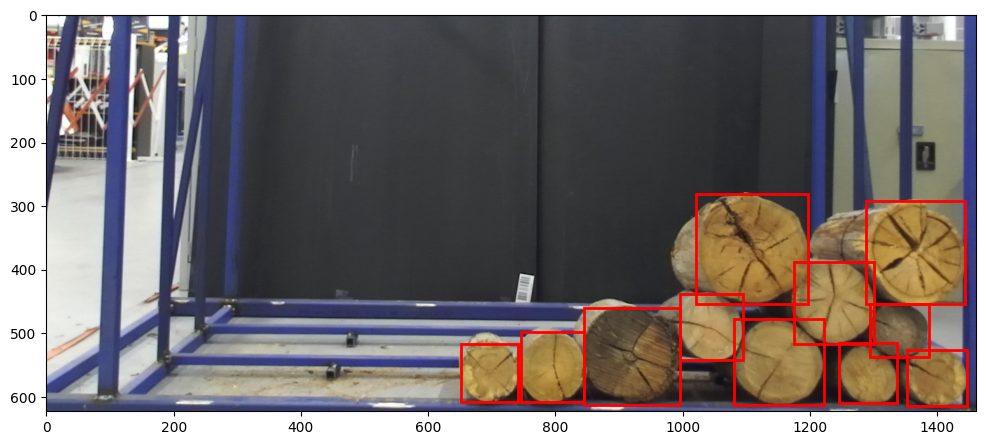

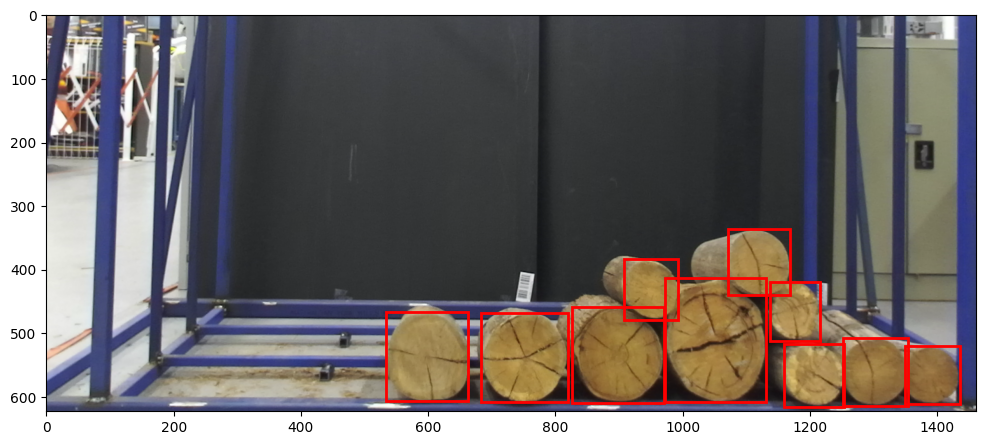

In [ ]:
%matplotlib inline

def visualize_image(dataset):
    if len(dataset) == 0:
        print("The dataset is empty.")
        return

    # Randomly select an image
    idx = random.randint(0, len(dataset) - 1)
    img, target = dataset[idx]
    img = img.permute(1, 2, 0).numpy()  # convert from (C, H, W) to (H, W, C)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)

    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()
    masks = target['masks'].numpy()

    # Draw bounding box
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

    plt.show()

visualize_image(train_dataset)
visualize_image(test_dataset)

In [ ]:
# allow access using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class MaskRCNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MaskRCNNModel, self).__init__()

        # Load a pre-trained Mask R-CNN model with a ResNet-50-FPN backbone
        self.model = models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)

        # Update the head of the model to match the number of classes (including the background)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

        # Update the mask predictor to match the number of classes
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        self.model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
            in_features_mask, hidden_layer, num_classes
        )

    def forward(self, images, targets=None):
        return self.model(images, targets)

mask_rcnn = MaskRCNNModel().to(device)
print(mask_rcnn)

MaskRCNNModel(
  (model): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, mome

In [ ]:
# specify optimizer (adam: adaptive moment estimation) and learning rate = 0.01
params = [p for p in mask_rcnn.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=0.001, weight_decay=0.01)

# specify scheduler for finding global optimal
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=2, factor=0.5)

In [ ]:
def train_one_epoch(model, train_loader, optimizer, device):
    model.train()
    train_loss = 0.0
    total_train = 0

    # Training Loop
    for images, targets in tqdm(train_loader, desc="Training"):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        total_train += 1

    return train_loss / len(train_loader)

In [ ]:
# Number of epochs
n_epochs = 3
lowest_loss = float('inf')

os.makedirs(f'{DATA_DIR}/models', exist_ok=True)

for epoch in tqdm(range(n_epochs), desc="Epochs"):
    train_loss = train_one_epoch(
        mask_rcnn, train_loader, optimizer, device
    )

    scheduler.step(train_loss)

    print('Epoch: {} \tTraining Loss: {:.4f}'.format(epoch + 1, train_loss))

    if train_loss < lowest_loss:
        print(f'Validation loss decreased ({lowest_loss:.4f} --> {train_loss:.4f}). Saving model...')
        lowest_loss = train_loss
        torch.save(mask_rcnn.state_dict(), f'{HOME_DIR}/models/best_maskRCNN.pt')
    else:
        print('No improvement in validation loss.')

Training: 100%|██████████| 147/147 [04:14<00:00,  1.73s/it]


Epoch: 1 	Training Loss: 0.3584
Validation loss decreased (inf --> 0.3584). Saving model...


Training: 100%|██████████| 147/147 [04:13<00:00,  1.73s/it]


Epoch: 2 	Training Loss: 0.1831
Validation loss decreased (0.3584 --> 0.1831). Saving model...


Training: 100%|██████████| 147/147 [04:15<00:00,  1.74s/it]


Epoch: 3 	Training Loss: 0.1714
Validation loss decreased (0.1831 --> 0.1714). Saving model...


Epochs: 100%|██████████| 3/3 [12:46<00:00, 255.60s/it]


In [ ]:
def visualize_predictions(image, output, score_threshold=0.3, save_path=None):
    """
    Visualize predicted bounding boxes, masks, labels with confidence score threshold, and log count.
    """
    image = (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)  # Convert the image to [0-255] range and uint8

    # Extract predicted bounding boxes, labels, scores, and masks
    pred_boxes = output['boxes'].cpu().numpy()
    pred_labels = output['labels'].cpu().numpy()
    pred_scores = output['scores'].cpu().numpy()
    pred_masks = output['masks'].cpu().numpy()

    # Filter predictions by confidence score
    high_conf_indices = pred_scores >= score_threshold
    pred_boxes = pred_boxes[high_conf_indices]
    pred_labels = pred_labels[high_conf_indices]
    pred_scores = pred_scores[high_conf_indices]
    pred_masks = pred_masks[high_conf_indices]

    # Count the number of logs
    log_count = (pred_labels == 1).sum()

    if len(pred_boxes) == 0:
        print("No boxes with confidence score above threshold.")
        return

    # Create figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    for box, label, score, mask in zip(pred_boxes, pred_labels, pred_scores, pred_masks):
        xmin, ymin, xmax, ymax = map(int, box)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label_text = f"Log {label} ({score:.2f})"
        text_position = (xmin, ymin - 10) if ymin - 10 > 10 else (xmin, ymin + 20)
        ax.text(xmin, text_position[1], label_text, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        # Apply the mask
        mask = mask.squeeze()
        if mask.ndim == 2:  # Ensure mask has 2 dimensions
            rgba_mask = np.zeros((*mask.shape, 4), dtype=np.uint8)
            rgba_mask[:, :, 0] = mask * 255  # Red channel
            rgba_mask[:, :, 3] = mask * 240  # Alpha channel (transparency)
            ax.imshow(rgba_mask, cmap='Reds', alpha=0.5)
        else:
            print("Mask has unexpected number of dimensions:", mask.ndim)

    # Add title with log count
    plt.title(f"Threshold: {score_threshold * 100:.0f}% | Log count: {log_count}", fontsize=16)
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)  # Close the figure to free memory
    else:
        plt.show()

In [ ]:
def evaluate_model(model, test_loader, device, save_dir=None, score_threshold=0.8, max_images=100):
    """
    Evaluate the model on the test_loader and visualize/save the predictions.
    """
    model.eval()
    images_saved = 0  # Counter for saved images
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(test_loader, desc="Evaluating")):
            images = [image.to(device) for image in images]
            outputs = model(images)

            for img_idx, (image, output) in enumerate(zip(images, outputs)):
                if images_saved >= max_images:
                    break  # Stop if we've saved enough images

                high_conf_indices = output['scores'] >= score_threshold
                high_conf_count = high_conf_indices.sum().item()
                print(f"Image {images_saved + 1}: High confidence outputs: {high_conf_count}")

                if len(output['boxes']) == 0:
                    print("No boxes with confidence score above threshold.")
                    continue

                if save_dir:
                    save_path = os.path.join(save_dir, f"image_{images_saved + 1}.png")
                    visualize_predictions(
                        image.cpu(),
                        output,
                        score_threshold=score_threshold,
                        save_path=save_path
                    )

                images_saved += 1

            if images_saved >= max_images:
                break

In [ ]:
# Create output folder
save_path = '/content/drive/MyDrive/COS40007/Portfolio4/Results/rcnn_test'
mask_rcnn = MaskRCNNModel(num_classes=2).to(device)
mask_rcnn.load_state_dict(torch.load(f'{HOME_DIR}/models/best_maskRCNN.pt'))

# Evaluate and visualize
evaluate_model(
    model=mask_rcnn,
    test_loader=test_loader,
    device=device,
    save_dir=save_path,
    score_threshold=0.8,
    max_images=12
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-22-ec4c24626099>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrus

Image 1: High confidence outputs: 11


Evaluating:   8%|▊         | 1/12 [00:04<00:54,  4.93s/it]

Image 2: High confidence outputs: 10


Evaluating:  17%|█▋        | 2/12 [00:10<00:50,  5.10s/it]

Image 3: High confidence outputs: 10


Evaluating:  25%|██▌       | 3/12 [00:13<00:38,  4.28s/it]

Image 4: High confidence outputs: 9


Evaluating:  33%|███▎      | 4/12 [00:16<00:30,  3.87s/it]

Image 5: High confidence outputs: 10


Evaluating:  42%|████▏     | 5/12 [00:20<00:25,  3.68s/it]

Image 6: High confidence outputs: 9


Evaluating:  50%|█████     | 6/12 [00:24<00:23,  3.89s/it]

Image 7: High confidence outputs: 11


Evaluating:  58%|█████▊    | 7/12 [00:27<00:18,  3.78s/it]

Image 8: High confidence outputs: 10


Evaluating:  67%|██████▋   | 8/12 [00:31<00:14,  3.64s/it]

Image 9: High confidence outputs: 11


Evaluating:  75%|███████▌  | 9/12 [00:35<00:11,  3.70s/it]

Image 10: High confidence outputs: 9


Evaluating:  83%|████████▎ | 10/12 [00:39<00:07,  3.80s/it]

Image 11: High confidence outputs: 11


Evaluating:  92%|█████████▏| 11/12 [00:42<00:03,  3.68s/it]

Image 12: High confidence outputs: 10


Evaluating:  92%|█████████▏| 11/12 [00:45<00:04,  4.16s/it]
